# Image Classification using Deep Learning with SVM

### Udacity Machine Learning Engineer Nanodegree - Capstone Porject
### Student: Pavlos Sakoglou

### Final CNN Model Training and Testing

=========================================================================================

As mentioned in the report file, after refining the model and adjusting the architecture, we expect this model to do better than the initial one, and as a result, better than the benchmark. This model is a regular CNN with a sigmoid activation at the end, since this is a 2-class classification problem. We will compare the results of this model against the results of the CNN-SVMC model, that uses an SVM classifier instead of the sigmoid at the penultimate layer. Below find the training process and results.

## 1. Import data and print data statistics

In [1]:
from sklearn.datasets import load_files      
from keras.utils import np_utils
from glob import glob
import numpy as np
import os

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    file_classes = np_utils.to_categorical(np.array(data['target']))
    return files, file_classes

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of class names
class_names = os.listdir("data/train")

# print statistics about the dataset
print('There are %d total classes:' % len(class_names))
print(class_names[0], class_names[1], "\n")
print('There are %s total images\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images' % len(train_files))
print('There are %d validation images' % len(valid_files))
print('There are %d test images'% len(test_files))

Using TensorFlow backend.


There are 2 total classes:
nude safe 

There are 13606 total images

There are 12302 training images
There are 467 validation images
There are 837 test images


## Convert the data into 244x244 dimensions of RGB values

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

### Helper functions

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors) 

### Convert to RGB tensors

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print("Data are preprocessed!")

100%|████████████████████████████████████████| 837/837 [01:06<00:00, 12.55it/s]


Data are preprocessed!


# Refined network architecture

## Final CNN with sigmoid

In [3]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

# CNN with sigmoid

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

## Compile the final CNN model

In [4]:
# CNN with sigmoid
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Train the CNN model

#### Helper functions to plot training statistics

In [5]:
# helpers for training CNNs
import keras
import timeit
import matplotlib.pyplot as plt

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show() 

# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

#### Train the model

In [6]:
from keras.callbacks import ModelCheckpoint  

epochs = 20
batch_size = 16
epochtimer = EpochTimer()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.finalCNN.hdf5',
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_targets, 
                         validation_data=(valid_tensors, valid_targets),
                         epochs=epochs, batch_size=batch_size, verbose=0,
                         callbacks=[checkpointer, epochtimer])

Epoch 00000: val_loss improved from inf to 0.70759, saving model to saved_models/weights.best.finalCNN.hdf5
Epoch 0 took 1593.702948846574 seconds
Epoch 00001: val_loss improved from 0.70759 to 0.70361, saving model to saved_models/weights.best.finalCNN.hdf5
Epoch 1 took 1212.3980831684728 seconds
Epoch 00002: val_loss did not improve
Epoch 2 took 1202.105263653073 seconds
Epoch 00003: val_loss improved from 0.70361 to 0.58932, saving model to saved_models/weights.best.finalCNN.hdf5
Epoch 3 took 1204.2705117908536 seconds
Epoch 00004: val_loss did not improve
Epoch 4 took 1207.8752079468404 seconds
Epoch 00005: val_loss improved from 0.58932 to 0.53534, saving model to saved_models/weights.best.finalCNN.hdf5
Epoch 5 took 1792.3494045770976 seconds
Epoch 00006: val_loss improved from 0.53534 to 0.51237, saving model to saved_models/weights.best.finalCNN.hdf5
Epoch 6 took 1593.2463989380503 seconds
Epoch 00007: val_loss did not improve
Epoch 7 took 1738.3509000837348 seconds
Epoch 00008:

#### Plot results

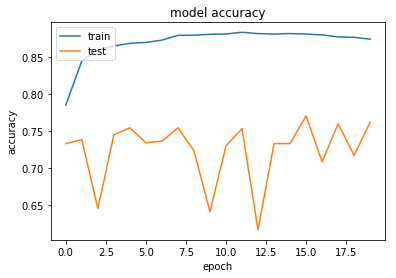

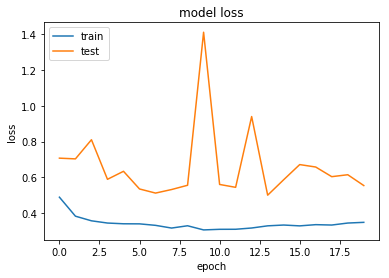

In [7]:
show_history_graph(hist)

## Test the final CNN model

In [8]:
# Load optimal weights from the training
model.load_weights('saved_models/weights.best.finalCNN.hdf5')

# get index of prediction for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report on metrics

TP = 0  # true positives
TN = 0  # true negatives
FP = 0  # false positives
FN = 0  # false negatives

k = 0
for i in predictions:
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 1:
        TP = TP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 0:
        TN = TN + 1
    if i == 1 and np.argmax(test_targets, axis=1)[k] == 0:
        FP = FP + 1
    if i == 0 and np.argmax(test_targets, axis=1)[k] == 1:
        FN = FN + 1
        
    k = k + 1
    
### Accuracy
accuracy = 100 * (TP + TN) / len(predictions)

### Precision
precision = 100 * TP / (TP + FP)

### Recall
recall = 100 * TP / (TP + FN)

### F3-score
# Divide by 100 to scale the score back to [0, 1]
b = 3
fbscore = (1 / 100) * (1 + b*b) * precision * recall / (b * b * precision + recall)

### Print results
print("Test accuracy: %.4f%%" % accuracy)
print("Test Precision: %.4f%%" % precision)
print("Recall: %.4f%%" % recall)
print("F3-score: ",  fbscore)

Test accuracy: 81.0036%
Test Precision: 81.6279%
Recall: 81.4385%
F3-score:  0.8145741471339059


### Discussion

The results look much more improved than the initial model, and better overall against the CNN-SVMC model. Although we value recall (true positives ratio) more than the other metrics, we still want a model that does an awful job with accuracy or precision -- like the CNN-SVMC. In addition, this model performs much better than the benchmark and as a result we will choose this model for our application. For further analysis, see the Results section in the report. 